In [102]:
from theFuncs import *

# DATA

In [103]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [104]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [105]:
ticker_data = get_ticker_data_multisource(
    sp100_tickers, 
    start="2006-01-02", 
    end="2021-11-01"
)
#start=2019-01-02
#end=2021-11-01

In [106]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [107]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [108]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [109]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    try:
        model = RollingOLS.from_formula(
            "(ret - DTB3) ~ (spy_ret - DTB3)", 
            data = ticker_data.loc[ticker], 
            window = 66
        ).fit(params_only=True)

        temp = model.params
        temp.columns = ["alpha", "Beta"]
        temp['ticker'] = ticker
        temp.set_index('ticker', inplace=True, append=True)
        temp = temp.reorder_levels(['ticker', 'date']).sort_index()
        df = pd.concat(
            [ 
                df, 
                temp
            ]
        )
    except:
        continue

ticker_data = ticker_data.join(df)

ticker_data.head()

high       low      open     close        volume  \
ticker date                                                               
AAPL   2006-01-04  2.713571  2.660714  2.683214  2.677500  6.196036e+08   
       2006-01-05  2.675000  2.633929  2.672500  2.656429  4.494224e+08   
       2006-01-06  2.739286  2.662500  2.687500  2.725000  7.044576e+08   
       2006-01-09  2.757143  2.705000  2.740357  2.716071  6.750408e+08   
       2006-01-10  2.924643  2.708214  2.723214  2.887857  2.279869e+09   

                        ret  spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                            
AAPL   2006-01-04  0.002943  93.228043  0.0409  0.004736    NaN   NaN  
       2006-01-05 -0.007870  93.286591  0.0410  0.000628    NaN   NaN  
       2006-01-06  0.025813  94.062912  0.0412  0.008322    NaN   NaN  
       2006-01-09 -0.003277  94.304581  0.0414  0.002569    NaN   NaN  
       2006-01-10  0.063248  94.399765  0.0419  0.001009    NaN   NaN

In [110]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2006-01-04  1.658989e+09
       2006-01-05  1.193859e+09
       2006-01-06  1.919647e+09
       2006-01-09  1.833459e+09
       2006-01-10  6.583936e+09

In [111]:
market_caps = market_caps.ewm(66).mean()

In [112]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2006-01-04  1.658989e+09
       2006-01-05  1.424675e+09
       2006-01-06  1.592153e+09
       2006-01-09  1.653847e+09
       2006-01-10  2.669741e+09

In [113]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2006-01-04,0.002943,NaN,0.001517,0.005461,-0.002596,0.001436,-0.004729,0.030769,-0.006936,NaN,...,0.002430,-0.000873,0.001324,0.003633,NaN,0.029296,-0.031064,-0.011599,0.001947,0.001710
2006-01-05,-0.007870,NaN,0.012876,0.007468,-0.009110,0.001291,-0.014504,-0.003198,0.008466,NaN,...,-0.003070,-0.011488,0.000397,0.004936,NaN,0.011513,-0.009095,-0.001110,-0.013601,-0.004951
2006-01-06,0.025813,NaN,0.019192,0.049528,0.024429,0.004297,-0.009135,0.015330,0.004617,NaN,...,0.019614,-0.007327,-0.005946,0.007859,NaN,-0.008852,-0.004819,0.005874,0.004159,0.019732
2006-01-09,-0.003277,NaN,0.037173,-0.002889,-0.015897,-0.004707,0.011268,0.021770,-0.016503,NaN,...,-0.023847,0.013871,0.012229,0.000325,NaN,0.004147,0.012451,-0.000158,-0.003705,-0.000505
2006-01-10,0.063248,NaN,-0.009668,-0.021571,0.005993,0.008885,-0.012661,-0.001375,-0.030374,NaN,...,0.019707,-0.002134,-0.005384,-0.004547,NaN,0.004130,-0.014348,-0.000789,0.003282,0.007744


In [114]:
rolling_correlations = ticker_data_wide.rolling(66).corr().fillna(0)
rolling_correlations.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2006-01-04 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2006-01-04 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [115]:
filter_correlations = rolling_correlations.groupby(["date"]).sum().sum(axis=1)
filter_correlations_dates = filter_correlations[filter_correlations > 0].index
rolling_correlations = rolling_correlations.loc[filter_correlations_dates]

In [116]:
rolling_covariances = ticker_data_wide.rolling(66).cov().fillna(0)
rolling_covariances.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2006-01-04 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2006-01-04 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [117]:
filter_covariances = rolling_covariances.groupby(["date"]).sum().sum(axis=1)
filter_covariances_dates = filter_covariances[filter_covariances > 0].index
rolling_covariances = rolling_covariances.loc[filter_covariances_dates]

In [118]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

date        ticker
2019-06-24  AAPL      0.000275
Name: AAPL, dtype: float64

In [119]:
# ticker_data.to_csv("data/test_run/ticker_data.csv")
# ticker_data_wide.to_csv("data/test_run/ticker_data_wide.csv")
# rolling_correlations.to_csv("data/test_run/rolling_correlations.csv")
# rolling_covariances.to_csv("data/test_run/rolling_covariances.csv")
# market_caps.to_csv("data/test_run/market_caps.csv")

In [120]:
# ticker_data = pd.read_csv("data/test_run/ticker_data.csv", index_col=[0, 1], parse_dates=True)
# ticker_data_wide = pd.read_csv("data/test_run/ticker_data_wide.csv", index_col=0, parse_dates=True)
# rolling_correlations = pd.read_csv("data/test_run/rolling_correlations.csv", index_col=[0, 1], parse_dates=True)
# rolling_covariances = pd.read_csv("data/test_run/rolling_covariances.csv", index_col=[0, 1], parse_dates=True)
# market_caps = pd.read_csv("data/test_run/market_caps.csv", index_col=[0, 1], parse_dates=True)

# CLUSTERING

In [121]:
date = get_closest_trading_day("2007-07-07", rolling_correlations)
K = 10

In [122]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MAXIMIZE)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0xf131cbe0
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 19.3212664
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 5.165989e+01, 715 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   51.65989    0  208   19.32127   51.65989   167%     -    0s
H    0     0                      51.6435730   51.65989  0.03%     -    0s


# INDEX BY CLUSTER WEIGHTS

In [123]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [124]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [125]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(1.072564055090908, 1.0289745236945667)

In [126]:
portfolio_returns - spy_returns

0.04358953139634125

In [127]:
get_portfolio_beta(center_weights, date, ticker_data)

1.0060068632171857

In [128]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [129]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 84 rows, 90 columns and 437 nonzeros
Model fingerprint: 0x6d0fdc64
Model has 4005 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 2e+00]
  Objective range  [1e-05, 2e-04]
  QObjective range [2e-08, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 81 rows and 80 columns
Presolve time: 0.01s
Presolved: 3 rows, 11 columns, 31 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 6.600e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.17529799e+05 -2.17576109e+05  7.12e+03 8.06e-03  3.57e+05     0s
   1   2.5

In [130]:
obj

0.0019138500827949535

In [131]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(1.081311230425265, 1.0289745236945667)

In [132]:
mean_var_step_return - spy_returns

0.052336706730698346

In [133]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

0.8824812616531768

# Method Comparison

In [134]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
JNJ,0.172210,0.071716
WFC,0.145981,0.154633
AXP,0.137298,0.066990
AAPL,0.137240,0.070239
ORCL,0.129585,0.221186
GOOG,0.106379,0.109540
HON,0.084600,0.058443
EMR,0.062064,0.036838
SO,0.016386,0.159104
LOW,0.008256,0.051310


# Master Func

In [135]:
start_date = get_closest_trading_day("2000-01-01", rolling_correlations)
end_date = max(ticker_data.index.get_level_values("date"))

master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

while start_date < end_date:
    master_func(
        start_date, 
        10, 
        rolling_correlations, 
        market_caps, 
        ticker_data, 
        ticker_data_wide, 
        rolling_covariances,
        0.5, 
        1.5, 
        1e-3, 
        master_cluster_index,
        master_cluster_performance,
        master_mean_var_index,
        master_mean_var_performance, 
        # GRB.MINIMIZE
        )

    start_date += relativedelta(months=3)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0xd3d5bea6
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 16.9065170
Presolve time: 0.06s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 4.778560e+01, 921 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   47.78560    0  168   16.90652   47.78560   183%     -    0s
H    0     0                      46.4803463   47.78560  2.81%     -    0s


In [136]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
2006-04-07 CAT    0.109066
           CL     0.020210
           CVX    0.032377
           GE     0.056793
           GOOGL  0.123291
...                    ...
2021-10-07 MDLZ   0.036085
           MET    0.147164
           MSFT   0.293530
           SO     0.012137
           XOM    0.177154

[630 rows x 1 columns]

In [137]:
method1_index.to_csv("./output/method1_index.csv")

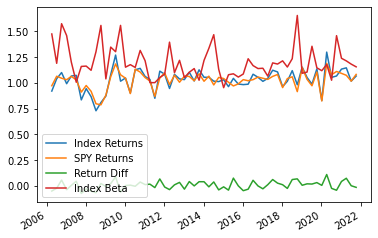

In [138]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.plot()
plt.savefig("./output/method1_performance_plot.png")

In [139]:
method1_performance.to_csv("./output/method1_performance.csv")

In [140]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

weight
2006-04-07 CAT    2.433087e-01
           CL     9.806121e-02
           CVX    9.895499e-02
           GE     1.230052e-04
           GOOGL  8.661727e-02
...                        ...
2021-10-07 MDLZ   4.486791e-08
           MET    7.780396e-01
           MSFT   2.219595e-01
           SO     3.647689e-08
           XOM    2.095798e-07

[580 rows x 1 columns]

In [141]:
method2_index.to_csv("./output/method2_index.csv")

In [142]:
method2_index.index.names = ['date', 'ticker']

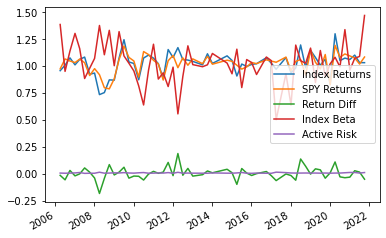

In [143]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.plot()
plt.savefig("./output/method2_performance_plot.png")

In [144]:
method2_performance.to_csv("./output/method2_performance.csv")

In [165]:
method1_index.index.names = ['date', 'tickers']
method2_index.index.names = ['date', 'tickers']

In [167]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix=" method 1", 
    rsuffix=" method 2"
)
comp_index

weight method 1  weight method 2
date       tickers                                  
2006-04-07 CAT             0.109066     2.433087e-01
           CL              0.020210     9.806121e-02
           CVX             0.032377     9.895499e-02
           GE              0.056793     1.230052e-04
           GOOGL           0.123291     8.661727e-02
...                             ...              ...
2021-10-07 MDLZ            0.036085     4.486791e-08
           MET             0.147164     7.780396e-01
           MSFT            0.293530     2.219595e-01
           SO              0.012137     3.647689e-08
           XOM             0.177154     2.095798e-07

[630 rows x 2 columns]

In [168]:
comp_index.to_csv("./output/comp_index.csv")

In [151]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix=" Method 1", 
    rsuffix=" Method 2"
).fillna(method="ffill")
comp_performance

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
2006-04-07,0.919926,0.971725,-0.051799,1.474890,0.955104,0.971725,-0.016621,1.383810,0.004624
2006-07-07,1.039704,1.064060,-0.024356,1.189723,1.005975,1.064060,-0.058085,0.948687,0.003258
2006-10-06,1.099906,1.044824,0.055082,1.574879,1.074006,1.044824,0.029183,1.137089,0.004268
2007-01-08,0.991723,1.030398,-0.038675,1.459420,1.009078,1.030398,-0.021320,1.301352,0.006051
2007-04-05,1.065937,1.062467,0.003470,1.202026,1.059620,1.062467,-0.002847,1.160254,0.009724
...,...,...,...,...,...,...,...,...,...
2020-10-07,1.066476,1.110457,-0.043981,1.458531,1.071915,1.110457,-0.038542,1.336148,0.007605
2021-01-07,1.133316,1.092014,0.041303,1.238658,1.058881,1.092014,-0.033133,0.959781,0.010338
2021-04-07,1.145787,1.073282,0.072504,1.213282,1.099698,1.073282,0.026415,1.069824,0.009963
2021-07-07,1.016295,1.016481,-0.000187,1.181873,1.030052,1.016481,0.013571,1.087694,0.004827


In [152]:
comp_performance.to_csv("./output/comp_performance.csv")

In [153]:
return_comp_performance = comp_performance[
    ["Return Diff Method 1", "Return Diff Method 2"]
].add(1).cumprod().fillna(method="ffill")
return_comp_performance

,Return Diff Method 1,Return Diff Method 2
2006-04-07,0.948201,0.983379
2006-07-07,0.925107,0.926260
2006-10-06,0.976063,0.953291
2007-01-08,0.938314,0.932967
2007-04-05,0.941570,0.930310
...,...,...
2020-10-07,1.236171,0.994259
2021-01-07,1.287228,0.961316
2021-04-07,1.380558,0.986710
2021-07-07,1.380300,1.000100


In [154]:
return_comp_performance.to_csv("./output/return_comp_performance.csv")

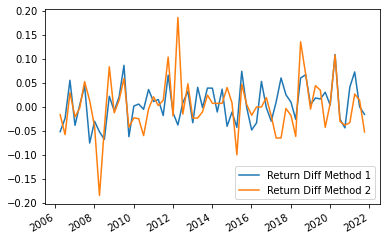

In [155]:
comp_performance.plot(y=["Return Diff Method 1", "Return Diff Method 2"])
plt.savefig("./output/comp_return_plot.png")

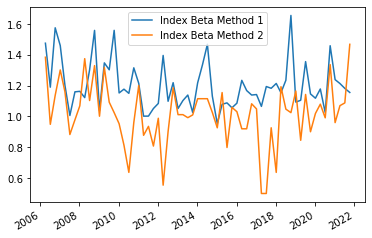

In [156]:
comp_performance.plot(y=["Index Beta Method 1", "Index Beta Method 2"])
plt.savefig("./output/comp_beta_plot.png")